In [ ]:
num_epochs     = 20
lr             = 1e-3
lr_bert        = 5e-5
test_size      = 0.2

Epoch 1/20 — loss: 4.4635
Epoch 2/20 — loss: 3.0639
Epoch 3/20 — loss: 1.9488
Epoch 4/20 — loss: 1.1888
Epoch 5/20 — loss: 0.7308
Epoch 6/20 — loss: 0.4524
Epoch 7/20 — loss: 0.2843
Epoch 8/20 — loss: 0.1954
Epoch 9/20 — loss: 0.1345
Epoch 10/20 — loss: 0.0979
Epoch 11/20 — loss: 0.0723
Epoch 12/20 — loss: 0.0487
Epoch 13/20 — loss: 0.0302
Epoch 14/20 — loss: 0.0192
Epoch 15/20 — loss: 0.0106
Epoch 16/20 — loss: 0.0066
Epoch 17/20 — loss: 0.0033
Epoch 18/20 — loss: 0.0019
Epoch 19/20 — loss: 0.0013
Epoch 20/20 — loss: 0.0009
Test Accuracy: 0.8497
Precision (macro): 0.8444
Recall    (macro): 0.8304
F1-score  (macro): 0.8355


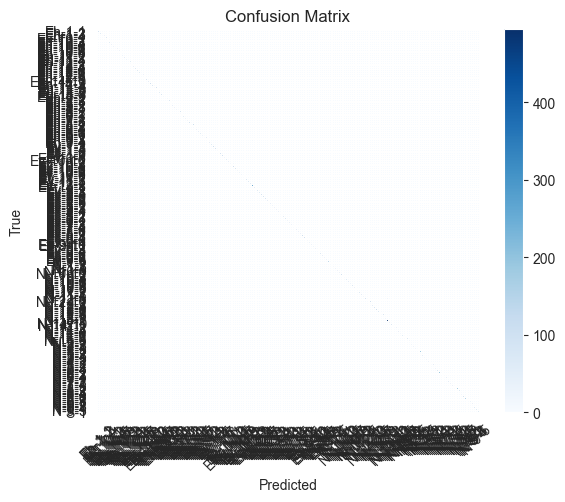

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# -----------------------------
# 0. Configuration
# -----------------------------
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir       = '../raw'                   # image dataset path
text_data_path = '../Sample Data Texts.xlsx' # text-data Excel file
image_size     = (32, 32)
batch_size     = 32
lr_image       = lr
weight_decay   = 1e-2

# -----------------------------
# 1. Image loading & preprocessing
# -----------------------------
images, labels = [], []
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    for fn in os.listdir(cls_path):
        if fn.lower().endswith(('.jpg', '.png', '.bmp', '.jpeg')):
            try:
                img = Image.open(os.path.join(cls_path, fn)).convert('L')
                img = img.resize(image_size)
                arr = np.array(img, dtype=np.float32) / 255.0
                images.append(arr)
                labels.append(cls)
            except Exception as e:
                print(f"Error reading {fn}: {e}")

images = np.stack(images)  # (N, H, W)
le     = LabelEncoder()
y      = le.fit_transform(labels)
num_classes = len(le.classes_)

class ImageDataset(Dataset):
    def __init__(self, imgs, lbls):
        self.imgs = imgs
        self.lbls = lbls
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        x = np.expand_dims(self.imgs[idx], 0)  # (1, H, W)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.lbls[idx], dtype=torch.long)

idx = np.arange(len(images))
tidx, vidx = train_test_split(idx, test_size=test_size, random_state=42, stratify=y)
train_ds = ImageDataset(images[tidx], y[tidx])
test_ds  = ImageDataset(images[vidx], y[vidx])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# -----------------------------
# 2. Text prior extraction + BERT fine-tuning
# -----------------------------
df = pd.read_excel(text_data_path)
combined_text = df['Type'].iloc[0] + ' ' + df['List of Store Names'].iloc[0]

tokenizer  = BertTokenizer.from_pretrained("bert-base-chinese")
bert_model = BertModel.from_pretrained("bert-base-chinese").to(device)

# Freeze all parameters
for p in bert_model.parameters():
    p.requires_grad = False
# Unfreeze the last two layers
for name, p in bert_model.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        p.requires_grad = True
bert_model.train()

# Pre-compute a fixed text vector and move it to GPU
with torch.no_grad():
    txt_inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, padding=True)
    txt_inputs = {k: v.to(device) for k, v in txt_inputs.items()}
    txt_vec = bert_model(**txt_inputs).last_hidden_state[:, 0, :].squeeze(0).to(device)  # (768,)

# -----------------------------
# 3. Simple HeteroGNN encoder (placeholder example)
# -----------------------------
class HeteroGNNEncoder(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.fc1 = nn.Linear(in_feats, hid_feats)
        self.fc2 = nn.Linear(hid_feats, out_feats)
    def forward(self, graph_dict):
        encs = []
        for feats in graph_dict.values():
            h = F.relu(self.fc1(feats.to(device)))
            encs.append(self.fc2(h))
        all_h = torch.cat(encs, dim=0)
        return all_h.mean(dim=0)

# Example graph data — replace with your real inputs
graph_data = {
    'type1': torch.randn(10, 16),
    'type2': torch.randn(15, 16)
}
hetero_enc = HeteroGNNEncoder(16, 32, 768).to(device)
with torch.no_grad():
    graph_vec = hetero_enc(graph_data).to(device)  # (768,)

# -----------------------------
# 4. ResNet + gated-fusion model
# -----------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.down  = None
        if stride != 1 or in_planes != planes:
            self.down = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        idt = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.down:
            idt = self.down(x)
        return self.relu(out + idt)

class ResNetFusionGated(nn.Module):
    def __init__(self, block, layers, num_classes, in_ch=1, t_dim=768, g_dim=768):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(in_ch, 64, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)

        def make_layer(planes, blocks, stride):
            layer_list = [block(self.in_planes, planes, stride)]
            self.in_planes = planes * block.expansion
            for _ in range(1, blocks):
                layer_list.append(block(self.in_planes, planes))
            return nn.Sequential(*layer_list)

        self.layer1 = make_layer(64,  layers[0], 1)
        self.layer2 = make_layer(128, layers[1], 2)
        self.layer3 = make_layer(256, layers[2], 2)
        self.layer4 = make_layer(512, layers[3], 2)
        self.avgp   = nn.AdaptiveAvgPool2d((1, 1))

        # Gating weights
        self.w_img   = nn.Parameter(torch.tensor(1.0, device=device))
        self.w_text  = nn.Parameter(torch.tensor(1.0, device=device))
        self.w_graph = nn.Parameter(torch.tensor(1.0, device=device))

        self.fc = nn.Linear(512 + t_dim + g_dim, num_classes)

    def forward(self, x, text_vec, graph_vec):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        x = self.avgp(x).flatten(1)  # (B, 512)
        B = x.size(0)

        img_f   = x * self.w_img
        text_f  = text_vec.unsqueeze(0).expand(B, -1) * self.w_text
        graph_f = graph_vec.unsqueeze(0).expand(B, -1) * self.w_graph

        fused = torch.cat([img_f, text_f, graph_f], dim=1)
        return self.fc(fused)

def build_model(n_cls):
    return ResNetFusionGated(BasicBlock, [2, 2, 2, 2], n_cls).to(device)

model = build_model(num_classes)

# -----------------------------
# 5. Optimizer & learning-rate scheduler
# -----------------------------
optimizer = optim.AdamW([
    {'params': model.parameters(),                       'lr': lr_img},
    {'params': bert_model.encoder.layer[10].parameters(),'lr': lr_bert},
    {'params': bert_model.encoder.layer[11].parameters(),'lr': lr_bert},
], weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.CrossEntropyLoss()

# -----------------------------
# 6. Training
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    bert_model.train()
    total_loss = 0.0

    for imgs, lbls in train_loader:
        imgs = imgs.to(device)
        lbls = lbls.to(device)

        inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        bert_out = bert_model(**inputs)
        batch_txt_vec = bert_out.last_hidden_state[:, 0, :].squeeze(0)  # (768,)

        optimizer.zero_grad()
        logits = model(imgs, batch_txt_vec, graph_vec)
        loss   = criterion(logits, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    scheduler.step()
    avg_loss = total_loss / len(train_ds)
    print(f"Epoch {epoch+1}/{num_epochs} — loss: {avg_loss:.4f}")

# -----------------------------
# 7. Testing & metric calculation
# -----------------------------
model.eval()
bert_model.eval()
all_true, all_pred = [], []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        lbls = lbls.to(device)

        inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        bert_out = bert_model(**inputs)
        batch_txt_vec = bert_out.last_hidden_state[:, 0, :].squeeze(0)

        out = model(imgs, batch_txt_vec, graph_vec)
        preds = out.argmax(dim=1)
        all_true.extend(lbls.cpu().tolist())
        all_pred.extend(preds.cpu().tolist())

# Accuracy
acc = (np.array(all_pred) == np.array(all_true)).mean()
print(f"Test Accuracy: {acc:.4f}")

# Precision, recall, F1-score
precision = precision_score(all_true, all_pred, average='macro')
recall    = recall_score(all_true, all_pred, average='macro')
f1        = f1_score(all_true, all_pred, average='macro')
print(f"Precision (macro): {precision:.4f}")
print(f"Recall    (macro): {recall:.4f}")
print(f"F1-score  (macro): {f1:.4f}")


